In [1]:
import time

from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib.ticker as ticker
import torch
from tqdm import tqdm

from threedeequadsim import quadsim, controller, trajectory, experiments, utils

import importlib
importlib.reload(controller)
importlib.reload(quadsim)
importlib.reload(trajectory)

<module 'threedeequadsim.trajectory' from 'c:\\Users\\mtoc1\\Documents\\github\\Online-Meta-Adaptive-Control-OMAC-Algorithm\\quadsim\\threedeequadsim\\trajectory.py'>

In [2]:
folder = './plots/' + time.strftime('%Y-%m-%d') + '/'
if not os.path.isdir(folder):
    os.makedirs(folder)
    print('Created data folder ' + folder)

In [3]:
# def savefig(plottag):
#     plt.savefig(folder + nametag + '_' + plottag, bbox_inches='tight')
def savefig(plottag):
    pass
xyz = ['x', 'y', 'z']

In [4]:
eta_a = 0.01

eta_A_convex = 0.002
eta_A_biconvex = 0.0001
eta_A_deep = 0.03

dim_a = 100
dim_A = 100

In [5]:
q_kwargs = {
    'Vwind' : np.array((3., 0., 0.)),  # mean wind speed
    'Vwind_cov' : 1.0,                # how quickly the wind changes
    'Vwind_gust' : 1.0,                # for hard wind constrant, wind speed is in the range Vwind +/- Vwind_gust
    'wind_constraint' : 'hard',
    't_stop' : 10.,
    'wind_update_period' : 5.0
}

In [6]:
CRTLS = [
    # controller.Baseline(),
    controller.MetaAdaptBaseline(eta_a_base=eta_a, dim_a=dim_a, dim_A=dim_A),
    controller.MetaAdaptConvex(eta_a_base=eta_a, eta_A_base=eta_A_convex, dim_a=dim_a, dim_A=dim_A),
    controller.MetaAdaptBiconvex(eta_a_base=eta_a, eta_A_base=eta_A_biconvex, dim_a=dim_a, dim_A=dim_A),
    controller.MetaAdaptDeep(eta_a_base=eta_a, eta_A_base=eta_A_deep, dim_a=dim_a)
]

In [7]:
T = trajectory.hover

t_kwargs = {
    'pd' : np.zeros(3)
}

In [8]:
Data = []

for c in CRTLS:
    np.random.seed(115) # if all random values are reset in c.reset_controller() instead of c.__init__(), 
                 # then setting seed here will make results reproducable
    q = quadsim.QuadrotorWithSideForce(**q_kwargs)
    t = T(**t_kwargs)

    data = q.run(trajectory=t, controller=c)
    Data.append(data)

1001it [00:11, 86.17it/s]                           
1001it [00:12, 82.26it/s]                           
1001it [00:11, 86.65it/s]                            
1001it [00:12, 80.17it/s]


baseline-omac
convex-omac
biconvex-omac
deep-omac


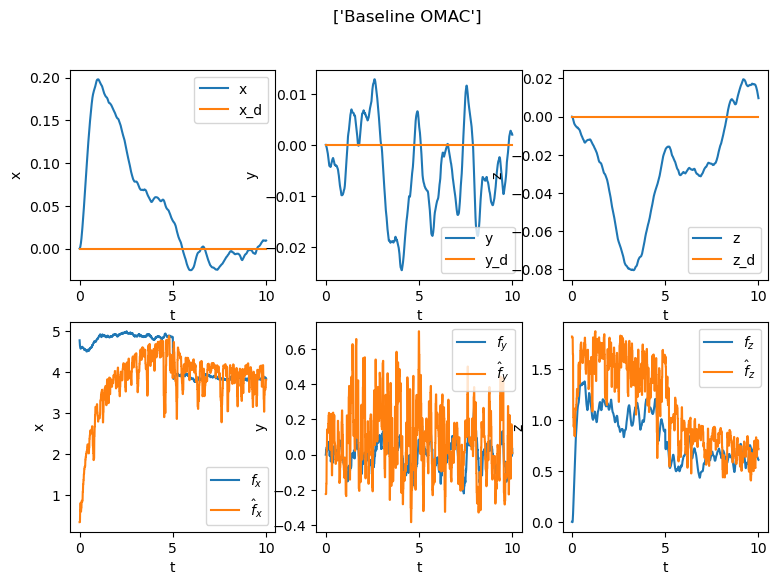

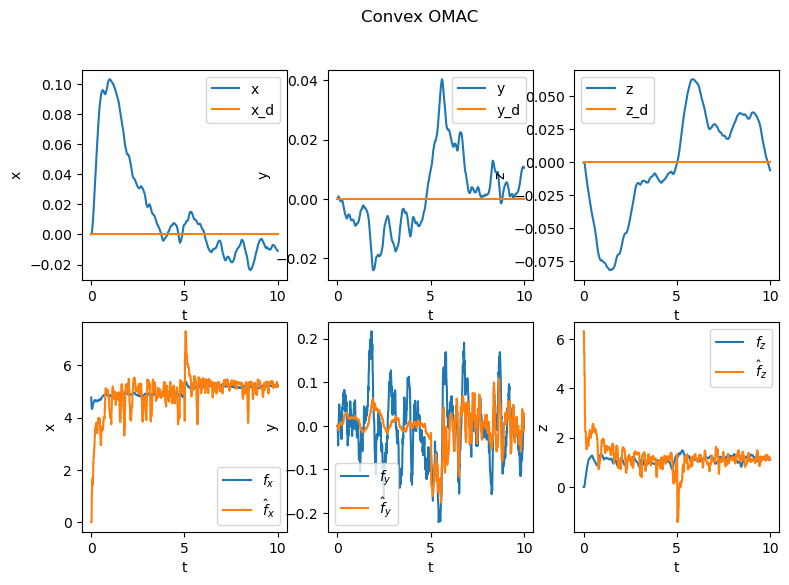

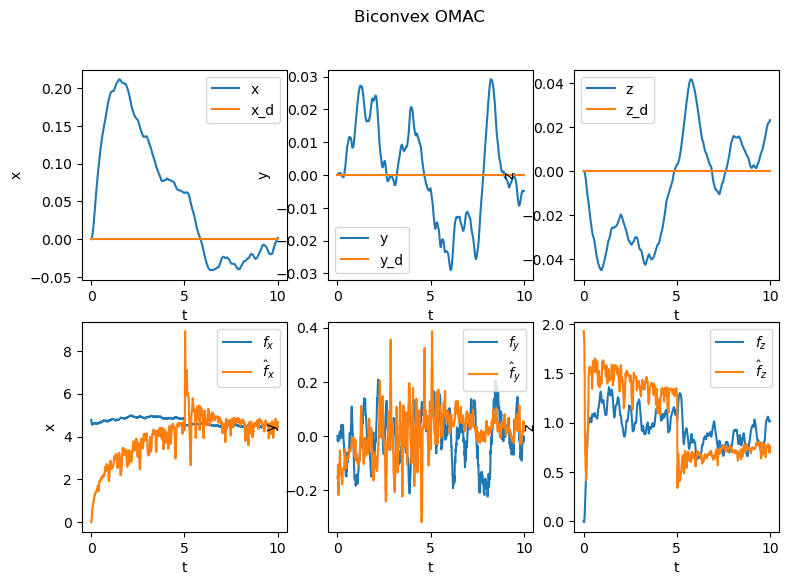

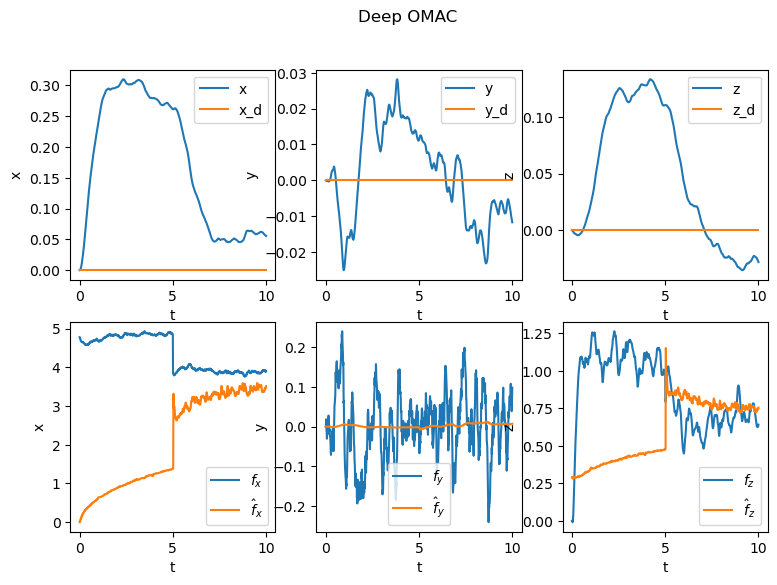

In [9]:
for j, data in enumerate(Data):
    if CRTLS[j]._name == 'baseline':
        continue

    print(CRTLS[j]._name)

    plt.figure(figsize=(9,6))

    # Plot position tracking
    for i in range(3):
        plt.subplot(2,3,i+1)
        plt.plot(data['t'], data['X'][:,i], label=xyz[i])
        plt.plot(data['t'], data['pd'][:,i], label=xyz[i] + '_d')
        # plt.plot(data['t'], data['Vwind'][:,i], label='Vwind_' + xyz[i])
        plt.legend()
        plt.xlabel('t')
        plt.ylabel(xyz[i])

    # Plot force estimation
    for i in range(3):
        plt.subplot(2,3,i+4)
        plt.plot(data['t'], data['Fs'][:,i], label=r'$f_' + xyz[i] + '$')
        plt.plot(data['t'], data['f_hat'][:,0,i], label=r'$\hat{f}_' + xyz[i] + '$')
        plt.legend()
        plt.xlabel('t')
        plt.ylabel(xyz[i])

    plt.suptitle(CRTLS[j].name_long)